In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import mplhep as hep

from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
import awkward as ak

plt.style.use(hep.style.CMS)
plt.clf()
plt.close("all")

# ordered as [edgecolor, facecolor]
mainblue = ["#42719f", "#6ab4ff"]
coralgreen = ["#117a65", "#138D75"]
reddish = ["#c82929", "#e42f2f"]
orangish = ["#d78939", "#e48a2f"]
blueish = ["#4387cb", "#2f89e4"]

plt.rcParams["font.family"] = "Helvetica Neue"

/opt/miniconda3/envs/coffea_torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [122]:

def PxPyPzE(v): # need this to be able to add four-vectors
    pt  = v[:,0:1]
    eta = v[:,1:2]
    phi = v[:,2:3]
    m   = v[:,3:4]
    
    Px, Py, Pz = pt*phi.cos(), pt*phi.sin(), pt*eta.sinh()
    E = (pt**2 + Pz**2 + m**2).sqrt()

    return torch.cat( (Px,Py,Pz,E), 1 )


def PtEtaPhiM(v):
    px = v[:,0:1]
    py = v[:,1:2]
    pz = v[:,2:3]
    e  = v[:,3:4]

    Pt  = (px**2+py**2).sqrt()
    ysign = py.sign()
    ysign = ysign + (ysign==0.0).float() # if py==0, px==Pt and acos(1)=pi/2 so we need zero protection on py.sign()
    Phi = (px/Pt).acos() * ysign
    Eta = (pz/Pt).asinh()

    M = F.relu(e**2 - px**2 - py**2 - pz**2).sqrt()

    return torch.cat( (Pt, Eta, Phi, M) , 1 ) 
    

## Load friend TTrees of the 3-fold model

In [8]:
train_region = 'preselection'
NanoAODSchema.warn_missing_crossrefs = False
# load files
'''threeTag = NanoEventsFactory.from_root(f'trained_on_{train_region}/threeTag_dec_trained_on_{train_region}.root', schemaclass = NanoAODSchema.v7, treepath = 'Events').events()
fourTag = NanoEventsFactory.from_root(f'trained_on_{train_region}/fourTag_10x_dec_trained_on_{train_region}.root', schemaclass = NanoAODSchema.v7, treepath = 'Events').events()'''
HH4b = NanoEventsFactory.from_root(f'../../data/HH4b_dec.root', schemaclass = NanoAODSchema.v7, treepath = 'Events').events()

HH4b_true = NanoEventsFactory.from_root(f'../../data/HH4b_picoAOD.root', schemaclass = NanoAODSchema.v7, treepath = 'Events').events()

## Concatenation of features

In [9]:
'''# threeTag
threeTag.Jet_pt     = ak.concatenate((threeTag.dec.Jet1_pt,     threeTag.dec.Jet2_pt,       threeTag.dec.Jet3_pt,   threeTag.dec.Jet4_pt))
threeTag.Jet_eta    = ak.concatenate((threeTag.dec.Jet1_eta,    threeTag.dec.Jet2_eta,      threeTag.dec.Jet3_eta,  threeTag.dec.Jet4_eta))
threeTag.Jet_phi    = ak.concatenate((threeTag.dec.Jet1_phi,    threeTag.dec.Jet2_phi,      threeTag.dec.Jet3_phi,  threeTag.dec.Jet4_phi))
threeTag.Jet_mass   = ak.concatenate((threeTag.dec.Jet1_mass,   threeTag.dec.Jet2_mass,     threeTag.dec.Jet3_mass, threeTag.dec.Jet4_mass))

# fourTag
fourTag.Jet_pt     = ak.concatenate((fourTag.dec.Jet1_pt,     fourTag.dec.Jet2_pt,       fourTag.dec.Jet3_pt,   fourTag.dec.Jet4_pt))
fourTag.Jet_eta    = ak.concatenate((fourTag.dec.Jet1_eta,    fourTag.dec.Jet2_eta,      fourTag.dec.Jet3_eta,  fourTag.dec.Jet4_eta))
fourTag.Jet_phi    = ak.concatenate((fourTag.dec.Jet1_phi,    fourTag.dec.Jet2_phi,      fourTag.dec.Jet3_phi,  fourTag.dec.Jet4_phi))
fourTag.Jet_mass   = ak.concatenate((fourTag.dec.Jet1_mass,   fourTag.dec.Jet2_mass,     fourTag.dec.Jet3_mass, fourTag.dec.Jet4_mass))'''

# HH4b
HH4b.Jet_pt     = ak.concatenate((HH4b.dec.Jet1_pt,     HH4b.dec.Jet2_pt,       HH4b.dec.Jet3_pt,   HH4b.dec.Jet4_pt))
HH4b.Jet_eta    = ak.concatenate((HH4b.dec.Jet1_eta,    HH4b.dec.Jet2_eta,      HH4b.dec.Jet3_eta,  HH4b.dec.Jet4_eta))
HH4b.Jet_phi    = ak.concatenate((HH4b.dec.Jet1_phi,    HH4b.dec.Jet2_phi,      HH4b.dec.Jet3_phi,  HH4b.dec.Jet4_phi))
#HH4b.Jet_mass   = ak.concatenate((HH4b.dec.Jet1_mass,   HH4b.dec.Jet2_mass,     HH4b.dec.Jet3_mass, HH4b.dec.Jet4_mass))

## Jet $p_{T}$

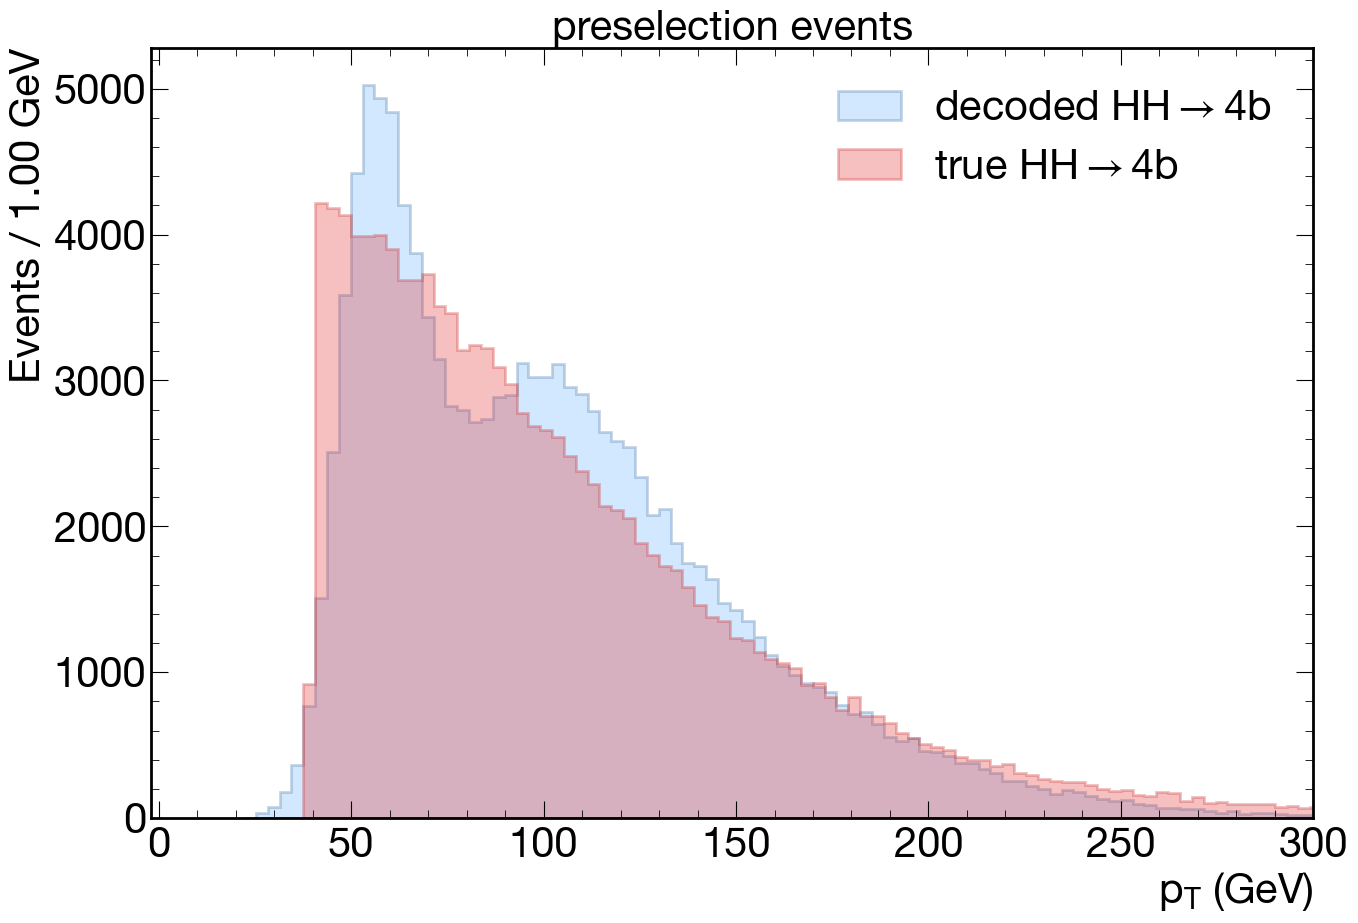

In [47]:
_min = 0.
_max = 100.
width = 1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(15, 10))

h1, bins1, _ = ax.hist(
    HH4b.Jet_pt,
    bins = nbins,
    histtype = 'stepfilled',
    ec = mainblue[0],
    facecolor = mainblue[1],
    alpha = .3,
    lw = 2.,
    label = r"$decoded\ HH \rightarrow 4b$"
)

h2, bins2, _ = ax.hist(
    ak.flatten(HH4b_true.Jet.pt),
    bins = bins1,
    histtype = 'stepfilled',
    ec = reddish[0],
    facecolor = reddish[1],
    alpha = .3,
    lw = 2.,
    label = r"$true\ HH \rightarrow 4b$"
)
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
ax.set_xlabel(r"$p_{T}\ (GeV)$", fontsize = 30)
ax.set_ylabel("Events / %.2f GeV" % width, fontsize = 30)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
ax.set_xlim(-2, 300)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 30)
ax.set_title("preselection events", fontsize = 30)
plt.savefig(f"plots/autoencoder/HH4b_dec_Jet_pt.pdf")